In [28]:
import pygmt
import imageio
import xarray as xr
import numpy as np
from scipy.ndimage import gaussian_filter

from scripts import visMap as vmap
from scripts import getDisplacements as dmaps

> In this notebook, we provide a workflow to adjust simulated elevations iteratively based on paleo-elevation maps when running an *unconstrained* simulation.


## Extracting the missmatch between model and observations

Considering a specific time step, we compare the `goSPL` elevations to what will be considered as the *truth* (i.e. the paleo-elevation from Scotese). This comparison consists in computing the differences between the 2 maps and applying a low-pass filter on these differences.


<img src="img/unconstrained.png"
     alt="Extracting tectonic forcing from unconstrained model"
     style="float: left; margin-right: 10px;" />




To extract the missmatch (tectonic), we use a Python class (`getDisplacements`). 

In [14]:
# Corresponding step where the missmatch is evaluated
step = 50

# goSPL model output directory
outputDir = 'step4'

# Initial goSPL mesh 
npdata = '../2-inputgen/gospldata/mesh_9_100Ma.npz'

# Initialise the Python class used to extract the missmatch
dmap = dmaps.getDisplacements(npdata, outputDir, step)

Once the class has been initialised, we provide the paleo-elevation observations (*truth*) that we want to compare our model against. (Note that this is done on each time step separetly)

In [15]:
dmap.getPaleoTopo(paleoDems='../1-data/ndem/95Ma.nc')

The `dispMap` function is then used to map the missmatch on a regular grid so we could then apply some filtering on this missmatch if needed.

Interpolatation of the missmatch from the unstructured `goSPL` mesh to a regular grid needs 2 parameters:

+ the resolution (`res` below) given in degrees,
+ the number of unstructured points used to perform the distance weighting interpolation (`nghb`). 

In [16]:
dmap.dispMap(res=0.1, nghb=3)

We then save the value as a netCDF file 

In [ ]:
# Output folder where new netcdf will be stored
folder = 'missmatch'

# Check whether the specified folder exists or not
isExist = os.path.exists(folder)

if not isExist:
  # Create the new directory because it does not exist 
  os.makedirs(folder)

In [ ]:
dmap.exportNetCDF(folder+'/step4_95.nc')

## Evaluating similarity and accuracy between model and observations

The approach below will have to performed iteratively until the fit between simulated elevations and observations is assumed good enough. To evaluate this fit we compute at each iteration of the fitting process a *score* of similarity and accuracy.


<img src="img/score.png"
     alt="Successive fitting of simulated elevations"
     style="float: left; margin-right: 10px;" />


To extract similarity and accuracy, we use a Python class (`visMap`). 

First, let's open the netcdf file that was created above...

In [24]:
ds = xr.open_dataset(folder+'/step4_95.nc')

# Observation (i.e truth)
obs = ds.nZ.values

# Simulated elevation from goSPL
sim = ds.Z.values

We can plot the two maps, to get a visual idea of the differences...

Paleo-elevation model elevation


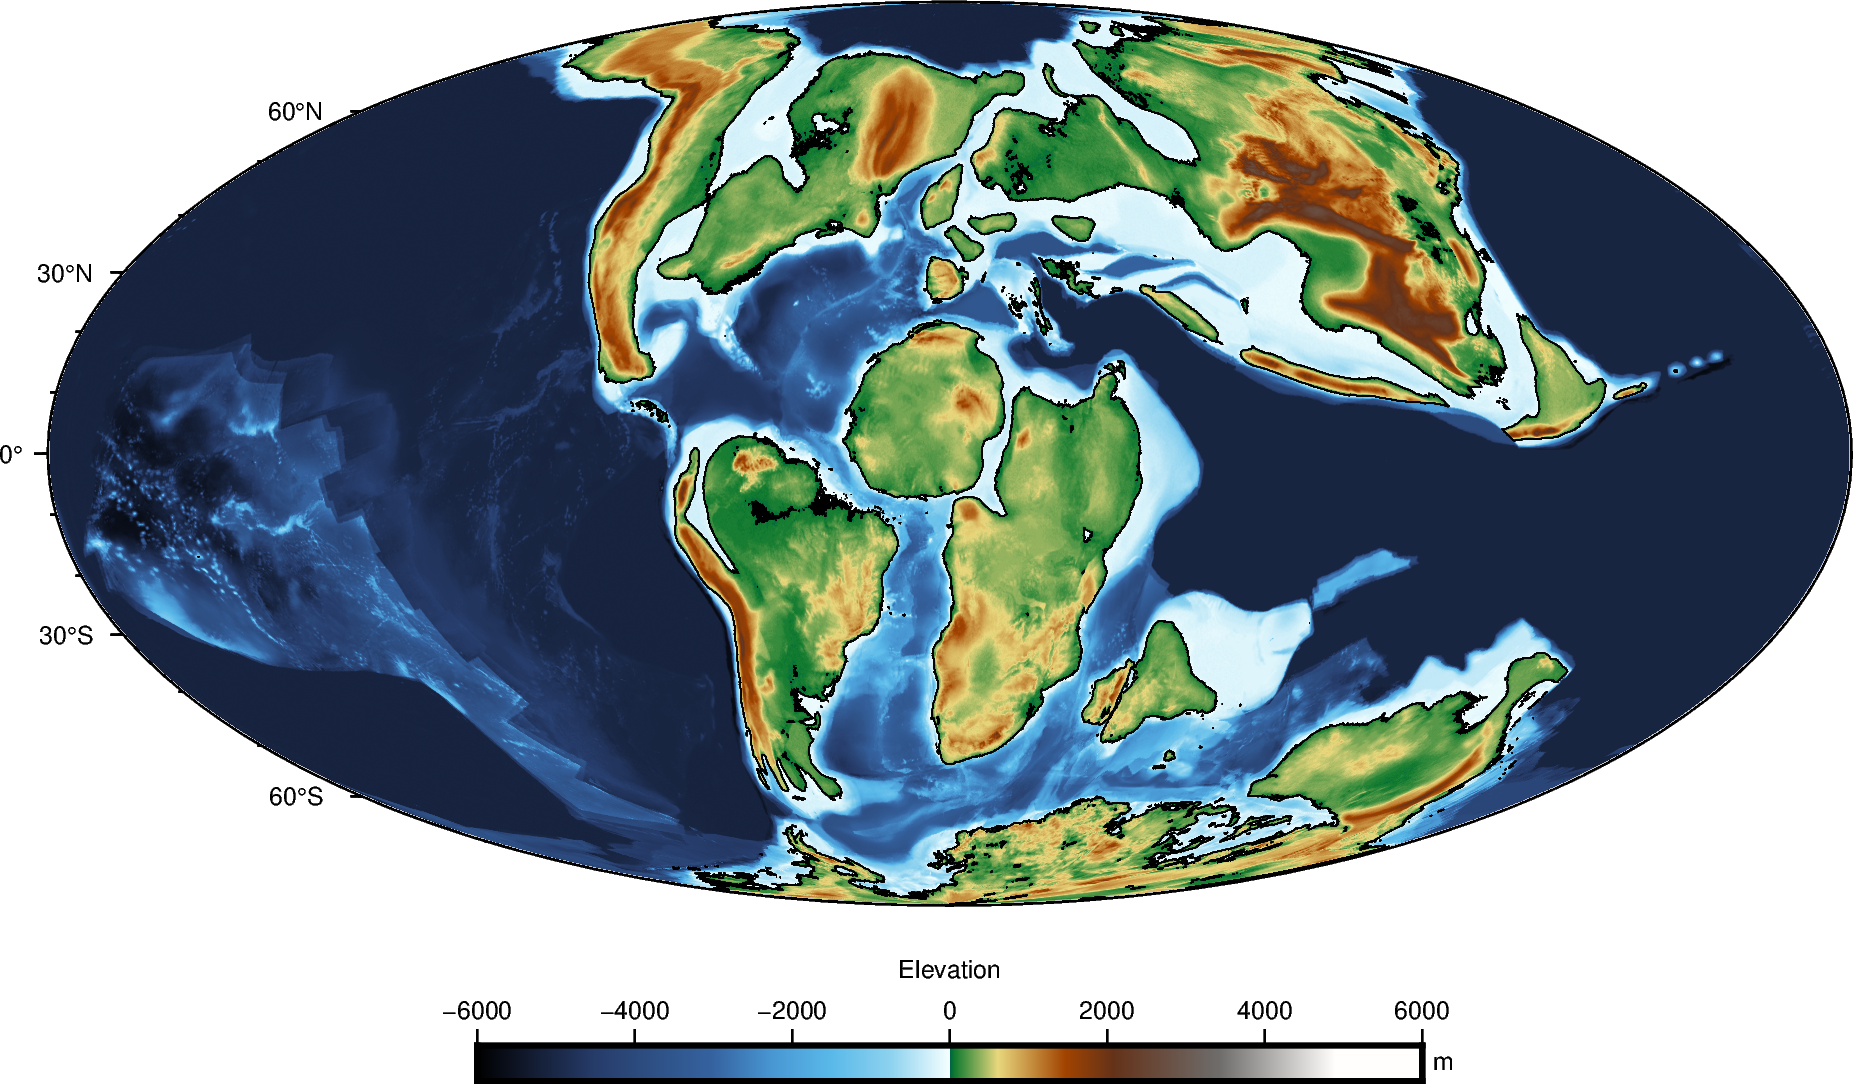

Simulated elevation


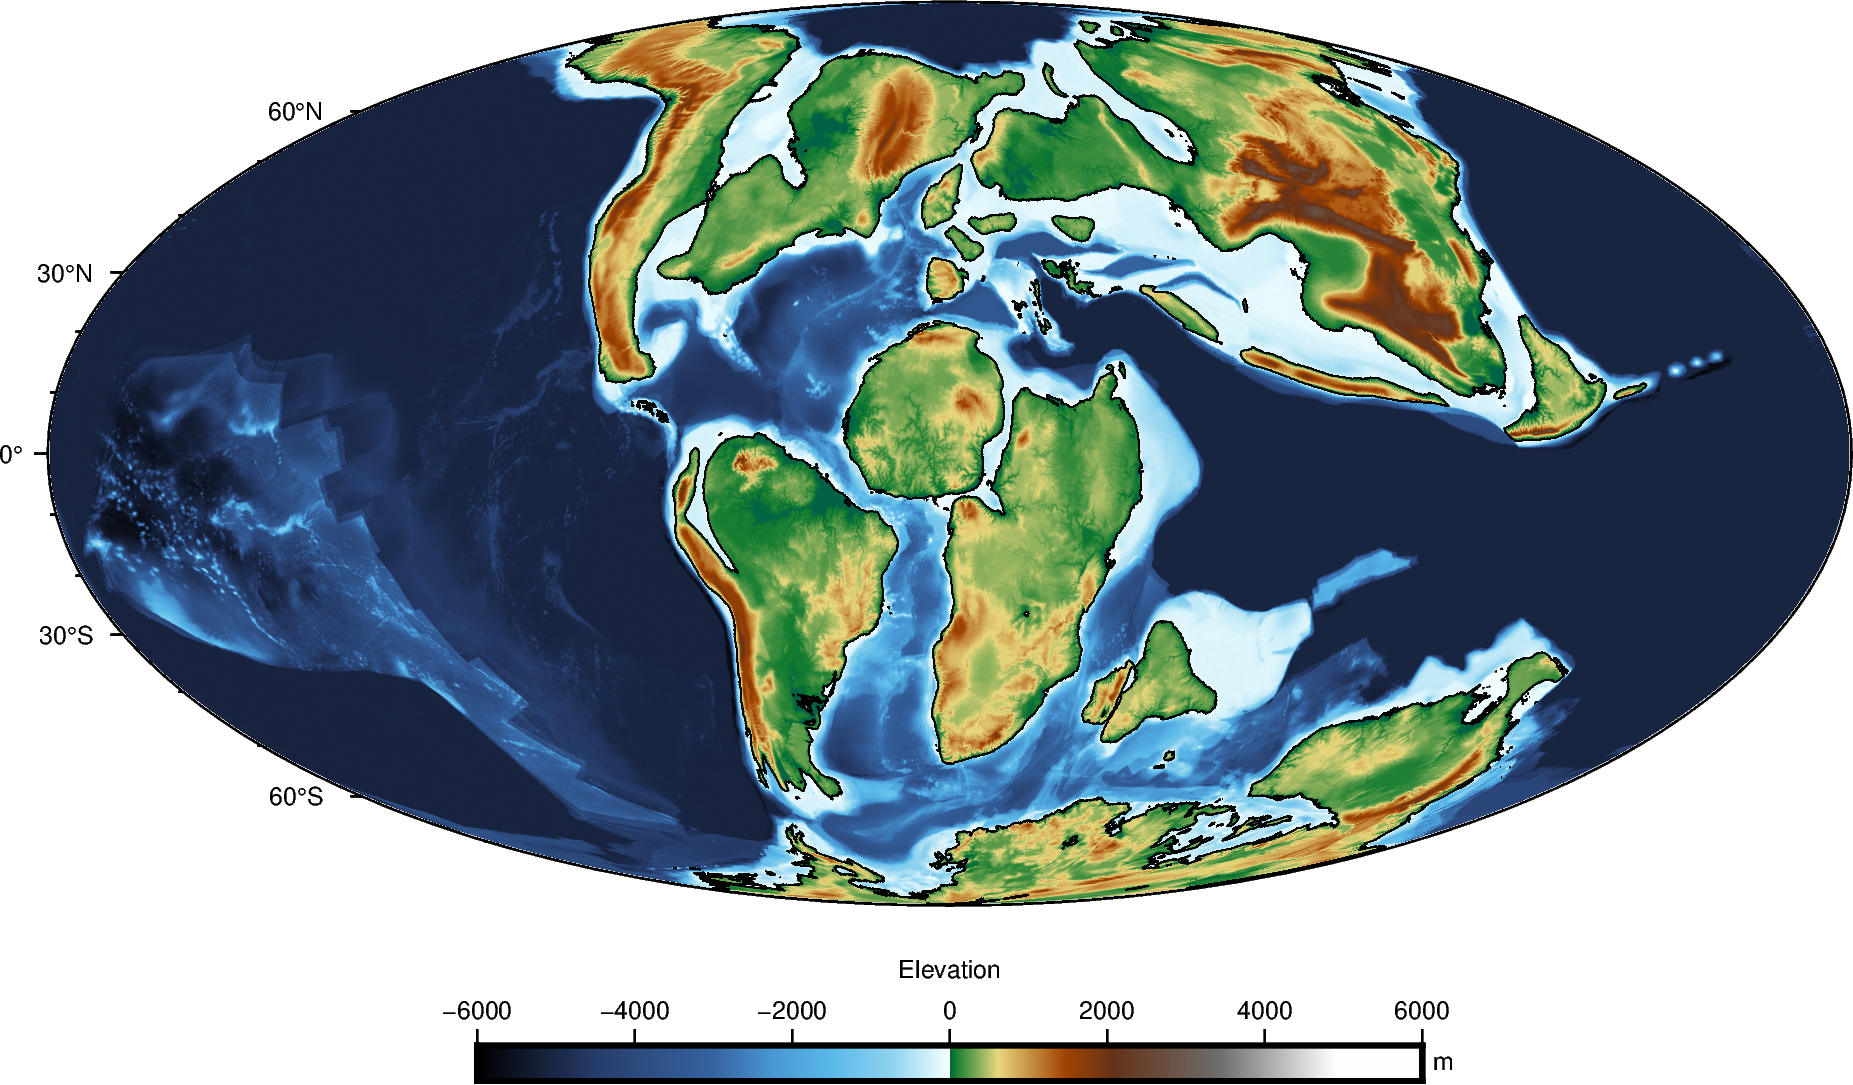

In [29]:
def plotElevation(dataZ):
    
    fig = pygmt.Figure()

    # Plotting elevation
    with pygmt.config(FONT='6p,Helvetica,black'):
        pygmt.makecpt(cmap="geo", series=[-6000, 6000])
        fig.basemap(region='d', projection='W6i', frame='afg')
        fig.grdimage(dataZ, shading='+a345+nt1+m0', frame=False)

        # Add contour
        fig.grdcontour(
            interval=0.1,
            grid=dataZ,
            limit=[-0.1, 0.1],
        )
        fig.colorbar(position="jBC+o0c/-1.5c+w8c/0.3c+h",frame=["a2000", "x+lElevation", "y+lm"])


    fig.show(width=1000) #fig.show(dpi=500, width=1000)

print('Paleo-elevation model elevation')
plotElevation(ds.nZ)

print('Simulated elevation')
plotElevation(ds.Z)

As well as the actual missmatch:

Missmatch between simulation and observation


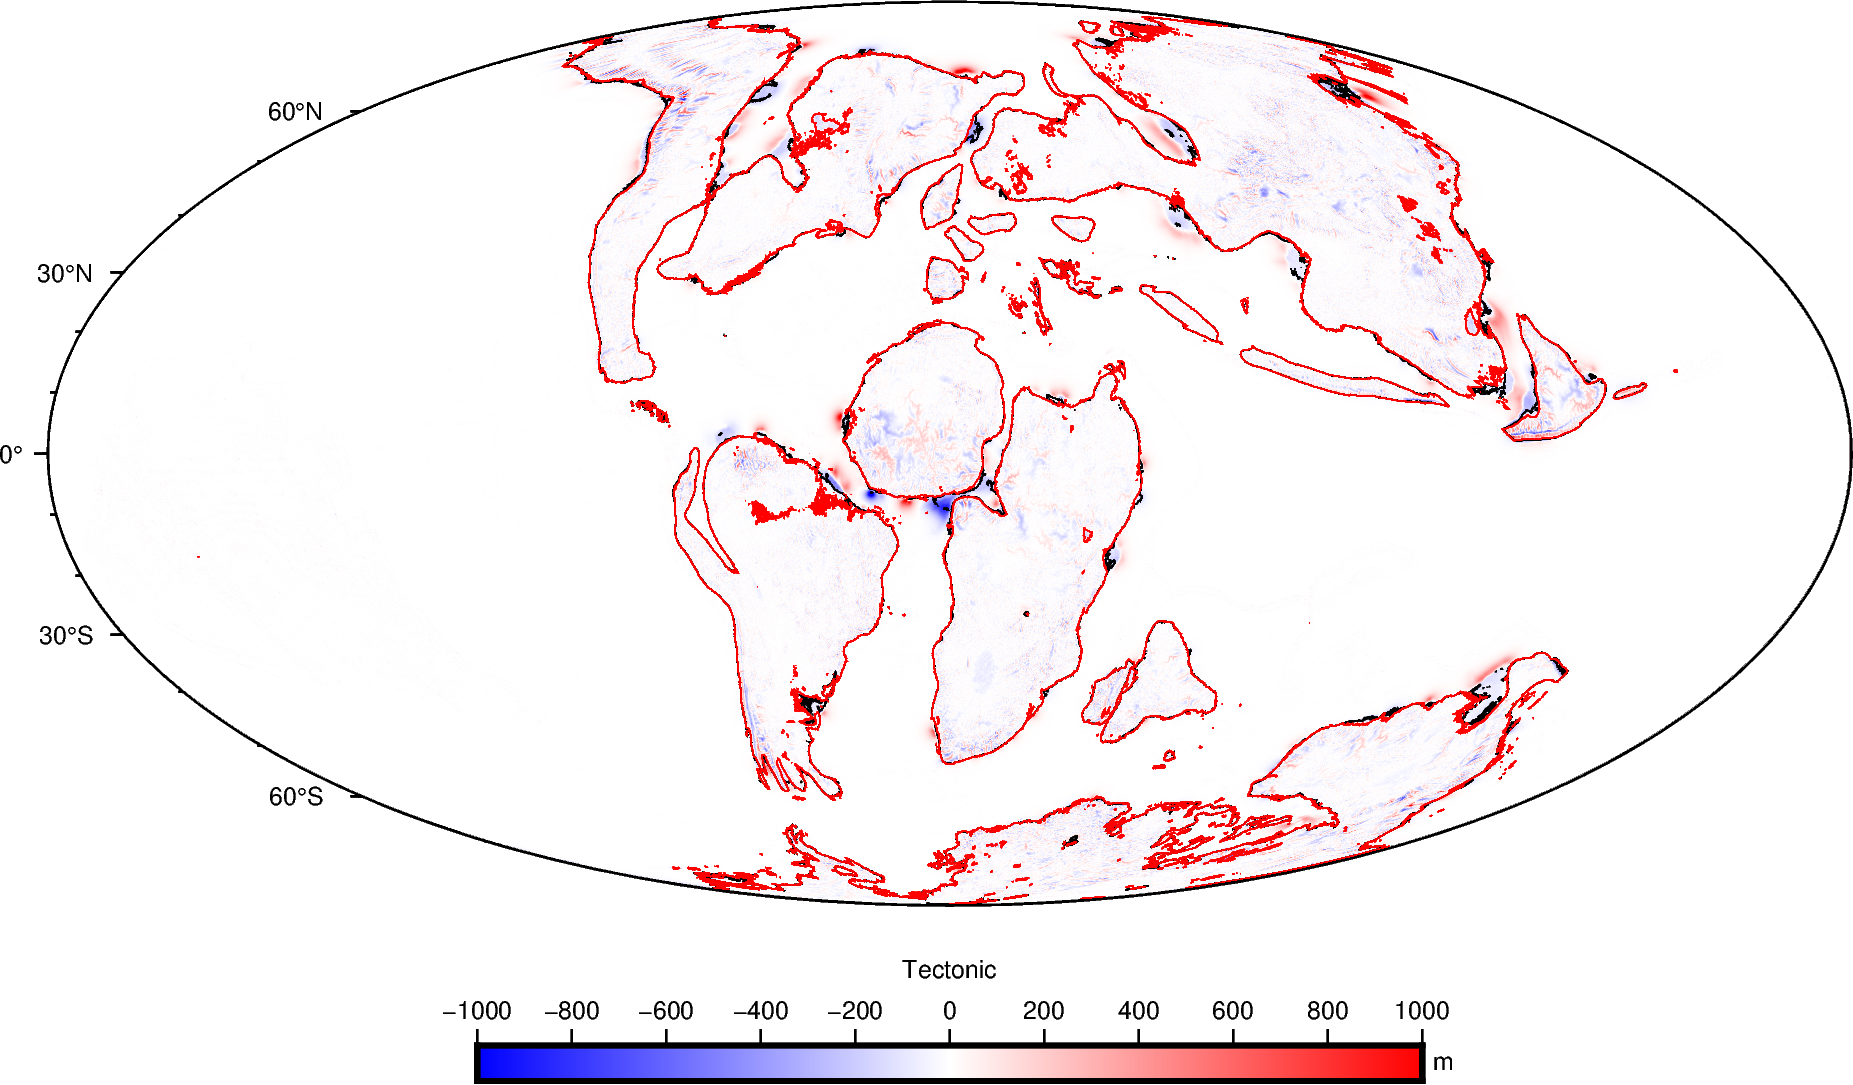

In [33]:
def plotMissmatch(dataZ, dataPaleo, dataTec):

    fig = pygmt.Figure()

    with pygmt.config(COLOR_FOREGROUND="red", COLOR_BACKGROUND="blue"):
        pygmt.makecpt(
            cmap="polar", 
            series=[-1000, 1000],
        )

        with pygmt.config(FONT='6p,Helvetica,black'):
            fig.basemap(region='d', projection='W6i', frame='afg')
            fig.grdimage(dataTec, shading='+a345+nt1+m0', frame=False)

            # Add contour
            fig.grdcontour(
                interval=0.1,
                grid=dataZ,
                limit=[-0.1, 0.1],
                pen="0.25p,black"
            )

            # Add contour
            fig.grdcontour(
                interval=0.1,
                grid=dataPaleo,
                limit=[-0.1, 0.1],
                pen="0.25p,red"
            )

            fig.colorbar(position="jBC+o0c/-1.5c+w8c/0.3c+h",frame=["a200", "x+lTectonic", "y+lm"])

    fig.show(width=1000)


print('Missmatch between simulation and observation')
plotMissmatch(ds.Z, ds.nZ, ds.disp)

Now we compute the score using the `accuracyScores` function where the `elevrange` parameter is used to compute the matching score for values which are above the provided range (absolute values).

In [25]:
similarity, accuracy = vmap.accuracyScores(obs, sim, elevrange=100.0)

We can then display the corresponding values from the different statistical correlations:

In [26]:
similarity

region  covariance  corrcoef  dotproduct    cosine   pearson            L1
0  global    0.999982  0.999980    0.999998  0.999993  0.999774  2.846576e+07
1   lands    0.999392  0.999143    0.999718  0.999550  0.984660  1.747751e+08
2   shelf    0.987440  0.991566    0.991328  0.993255  0.954727  3.532716e+07
3   ocean    0.999982  0.999980    0.999998  0.999993  0.999783  5.546306e+07

In [27]:
accuracy

region       RMSE        R2        MAE       LCC  nonmatching
0  global  53.640252  0.999547  20.139914  0.999774     0.048696
1   lands  76.356158  0.968624  44.915086  0.984548     0.108206
2   shelf  76.028778  0.898454  31.656056  0.952607     0.095089
3   ocean  22.011914  0.999565   3.078017  0.999782     0.003318

## Updating model input files to reduce missmatch



As presented in the figure above, one might want to update the model tectonic file to reduce the missmatch. 

> Obviously in addition to the tectonics, other parameters could be tuned such as erodibility, precipitation.

We also assume here that the paleo-elevation model holds the *truth* which is arguably not correct, but the approach here allow to better quantify how far we are for this model and could help to improve these models in a physically valid framework...

In most cases, we do want to account for the large wave-lenght components of this missmatch signal more than the higher ones that correspond to some specific geomorphic attributes which are actually not considered in the paleo-elevation model. 

To do so, we perform the filtering using a *lowpass Gaussian Filter* that eliminates high frequency (sharp) features.

In [31]:
# Getting the missmatch displayed above
disp = ds.disp.values

In [32]:
# Applying the filtering, the value of sigma could be changed.
# For example, for the first iteration you might want to use a value of 5, 
# then a value of 3 for the second, and a value of 2 for the third...
tecto = gaussian_filter(disp, sigma=2)

# You might also want to apply the filtering only on continental domain
# this can be done like this
tecto[ds.nZ<0] = disp[ds.nZ<0]

# Then we store the filtered signal in the xarray dataset
ds["sdisp"]=(['latitude', 'longitude'],  tecto)

Filtered missmatch between simulation and observation


grdgradient [WARNING]: Longitude range too small; geographic boundary condition changed to natural.
grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


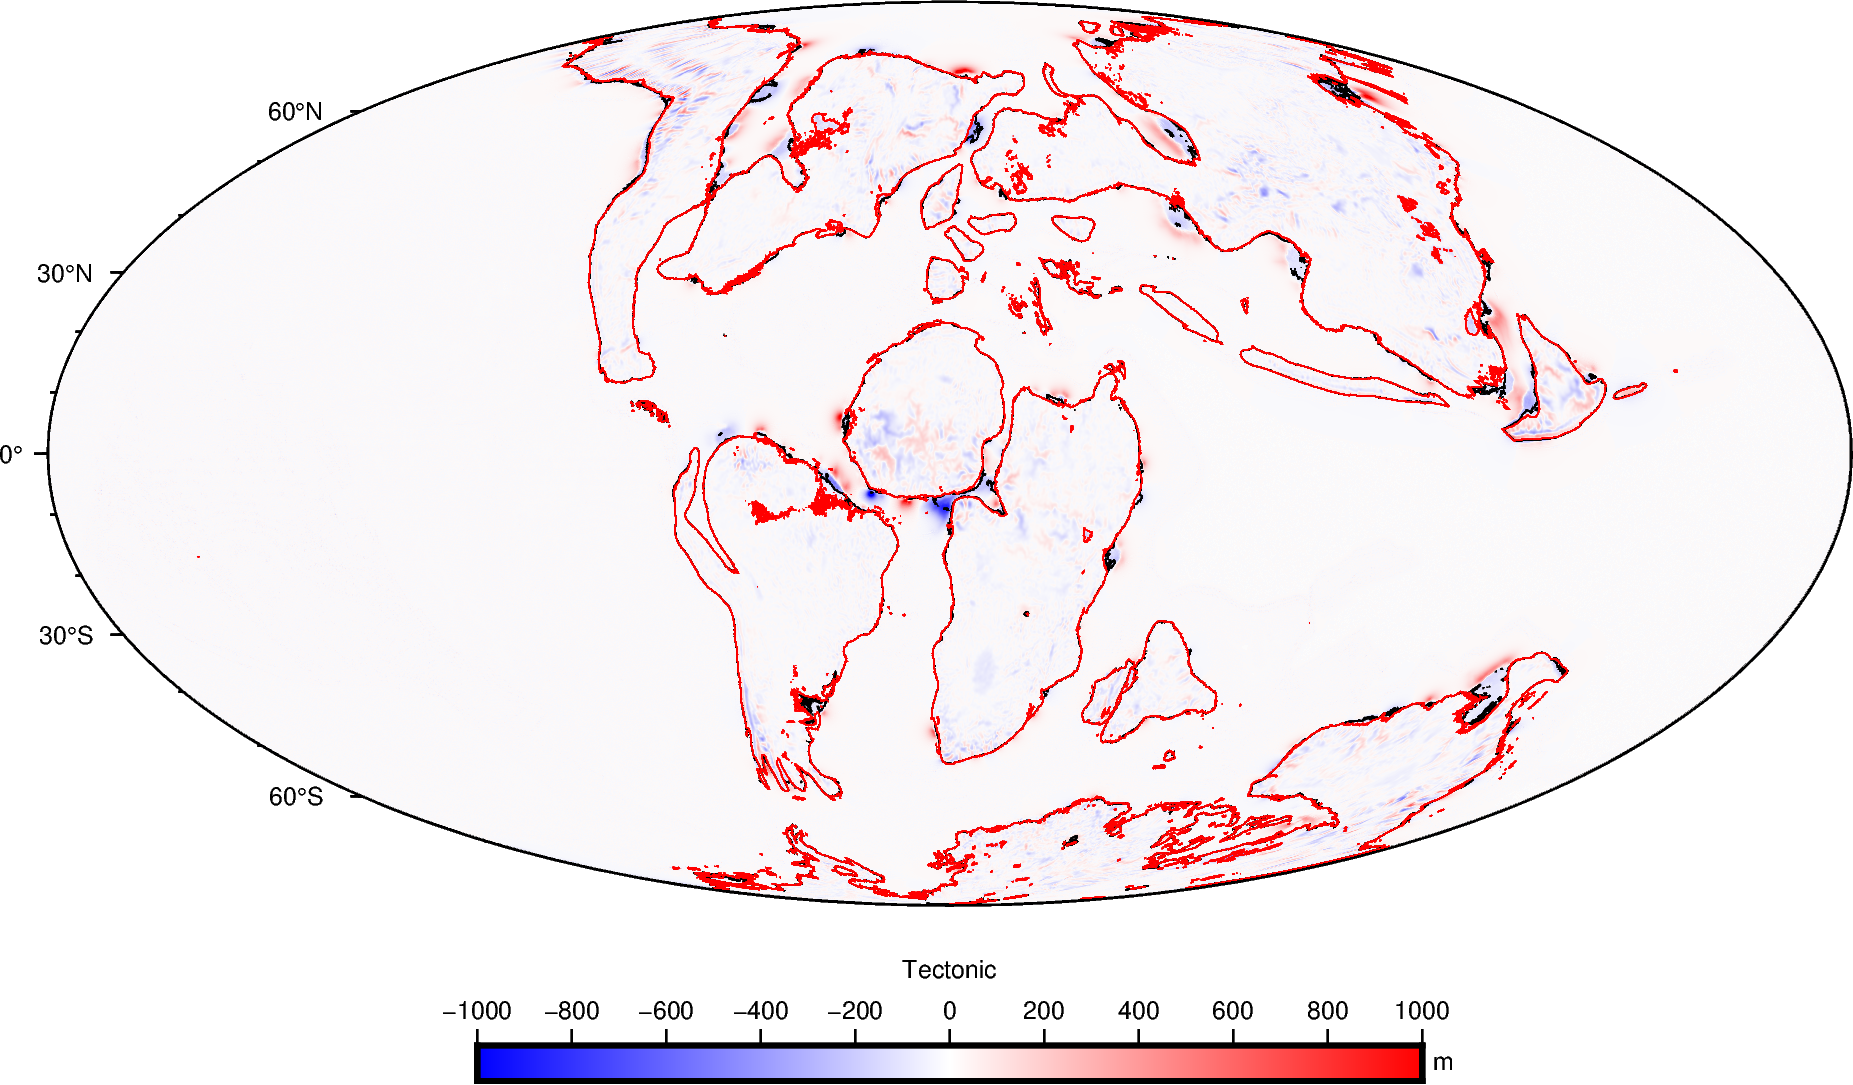

In [34]:
print('Filtered missmatch between simulation and observation')
plotMissmatch(ds.Z, ds.nZ, ds.sdisp)

We can then map the filtered missmatch on the `goSPL` mesh:

In [35]:
dmap.getSmoothDisp(ds.sdisp.values)

And save the `goSPL` dataset as a new input tectonic file for running a new simulation.


#### In case where this is the first matching iteration, you can directly save the data

In [37]:
# name = folder+'/it1_tect_100Ma'
# np.savez_compressed(name, t=dmap.sdisps)

#### If this is a subsequent iteration you will have to add the filtered missmatch to previously imposed tectonic forcing by doing:




In [38]:
# Reading previous iteration
data = np.load(folder+'/it2_tect_100Ma.npz')

# Creating the new forcing
name = folder+'/it3_tect_100Ma'
np.savez_compressed(name, t=dmap.sdisps+data['t'])